In [ ]:
import fastf1
from fastf1 import plotting
import matplotlib.pyplot as plt
from matplotlib import rcParams
import pandas as pd
import numpy as np
import pandas.api.types as ptypes
import seaborn as sns

SESSION_YEAR = 2024
SESSION_NAME = 'Sao Paulo'
SESSION_TYPE = 'R'

# Grand Prix race laps from each driver

## Get Session and laps

In [154]:
session = fastf1.get_session(SESSION_YEAR, SESSION_NAME, SESSION_TYPE)
session.load()

# Alle Quicklaps auswählen (echte Rennrunden)
laps = session.laps.pick_quicklaps()
# Sicherstellen, dass keine NaT in LapTime ist
laps = laps.dropna(subset=['LapTime']).copy()

drivers = session.drivers

events      WARNING 	Correcting user input 'Sao Paulo' to 'São Paulo Grand Prix'
core           INFO 	Loading data for São Paulo Grand Prix - Race [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core        WARNING 	No lap data for driver 23
core        WARNING 	Failed to perform lap accuracy check - all laps marked as inaccurate (driver 23)
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core  

## Race lap comparison

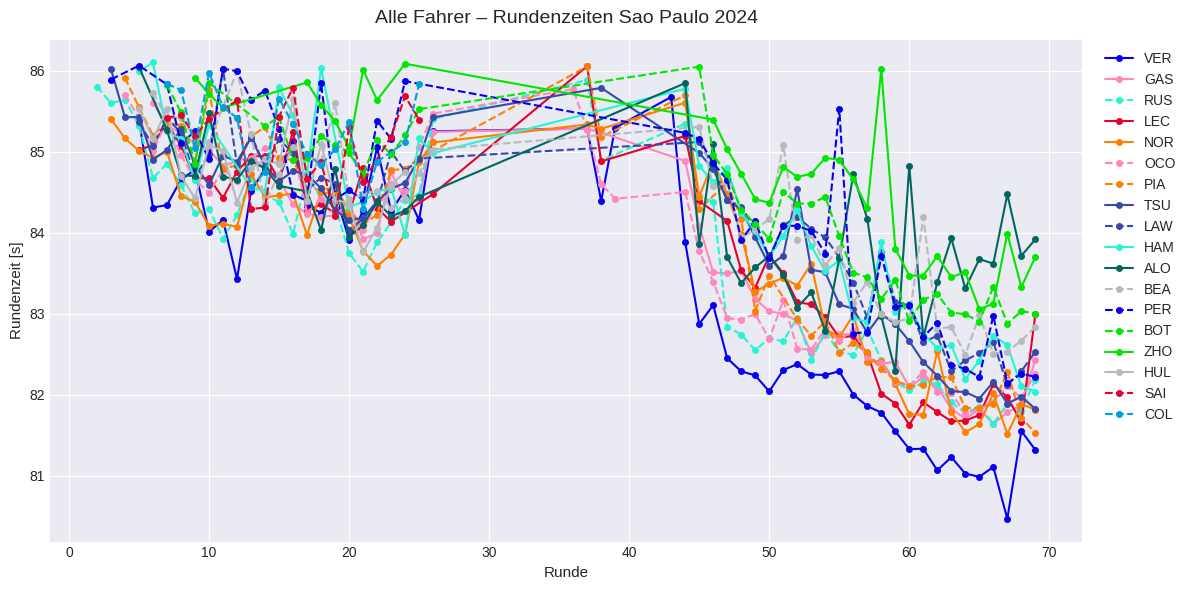

In [155]:
# Rundenzeiten in Sekunden umrechnen
laps['LapTime_sec'] = laps['LapTime'].dt.total_seconds()


# Fahrer sortieren nach durchschnittlicher Rundenzeit (für konsistente Farben/Legende)
driver_order = laps.groupby('Driver')['LapTime_sec'].mean().sort_values().index.tolist()

# Plot-Stil und Größe
plt.style.use('seaborn-v0_8-darkgrid')
rcParams['figure.figsize'] = (12, 6)

# Farben: colormap mit so vielen Farben wie Fahrer
n_drivers = len(driver_order)
cmap = plt.get_cmap('tab20', n_drivers) if n_drivers > 0 else plt.get_cmap('tab20')

# Plotten: jede Fahrerlinie etwas transparent, kleine Marker
fig, ax = plt.subplots()
for i, drv in enumerate(driver_order):
    d = laps[laps['Driver'] == drv]
    style = plotting.get_driver_style(identifier=drv, style=['color', 'linestyle'], session=session)
    if d.empty:
        continue
    ax.plot(d['LapNumber'], d['LapTime_sec'], marker='o', markersize=4, **style, label=drv)

# Achsen & Titel
ax.set_xlabel('Runde', fontsize=11)
ax.set_ylabel('Rundenzeit [s]', fontsize=11)
ax.set_title('Alle Fahrer – Rundenzeiten ' + SESSION_NAME + ' ' + str(SESSION_YEAR), fontsize=14, pad=12)

# Legende außerhalb des Plots (vermeidet Überlagerung)
ax.legend(loc='upper left', bbox_to_anchor=(1.01, 1), frameon=False, ncol=1)

plt.tight_layout()
plt.show()


## Weather Data for Grand Prix

In [156]:
# Get weather data
weather = session.weather_data

### Temperature, Humidity, WindSpeed

                      Time  AirTemp  Humidity  Pressure  Rainfall  TrackTemp  \
0   0 days 00:00:22.903000     22.2      86.0     927.4      True       27.3   
1   0 days 00:01:22.903000     22.3      87.0     927.3      True       26.2   
2   0 days 00:02:22.903000     22.1      86.0     927.4      True       26.4   
3   0 days 00:03:22.906000     22.1      87.0     927.4      True       26.4   
4   0 days 00:04:22.910000     22.1      87.0     927.3      True       26.2   
..                     ...      ...       ...       ...       ...        ...   
196 0 days 03:16:23.548000     20.5      89.0     925.5     False       24.2   
197 0 days 03:17:23.549000     20.5      89.0     925.5     False       24.1   
198 0 days 03:18:23.549000     20.5      89.0     925.4     False       24.0   
199 0 days 03:19:23.568000     20.5      89.0     925.4     False       24.0   
200 0 days 03:20:23.566000     20.5      89.0     925.4     False       24.1   

     WindDirection  WindSpeed  
0      

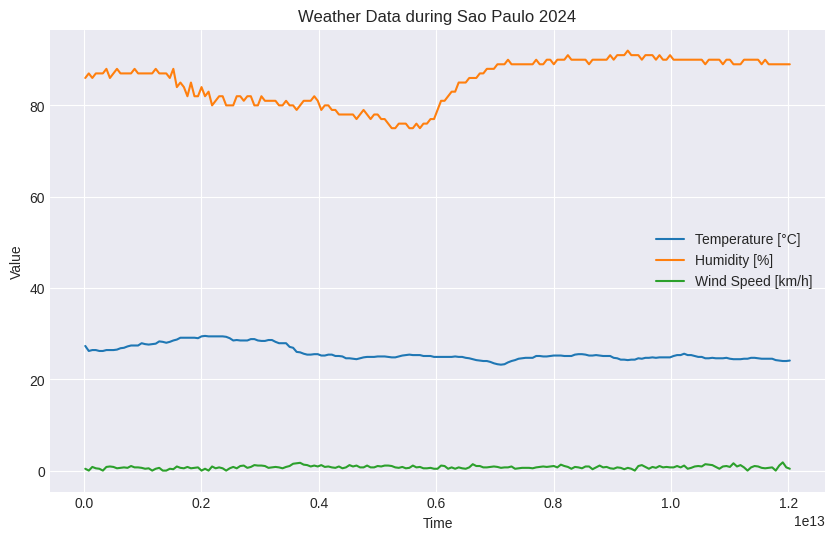

In [157]:
print(weather)
plt.figure(figsize=(10, 6))
plt.plot(weather['Time'], weather['TrackTemp'], label='Temperature [°C]')
plt.plot(weather['Time'], weather['Humidity'], label='Humidity [%]')
plt.plot(weather['Time'], weather['WindSpeed'], label='Wind Speed [km/h]')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Weather Data during ' + SESSION_NAME + ' ' + str(SESSION_YEAR))
plt.legend()
plt.show()


### Rainfall

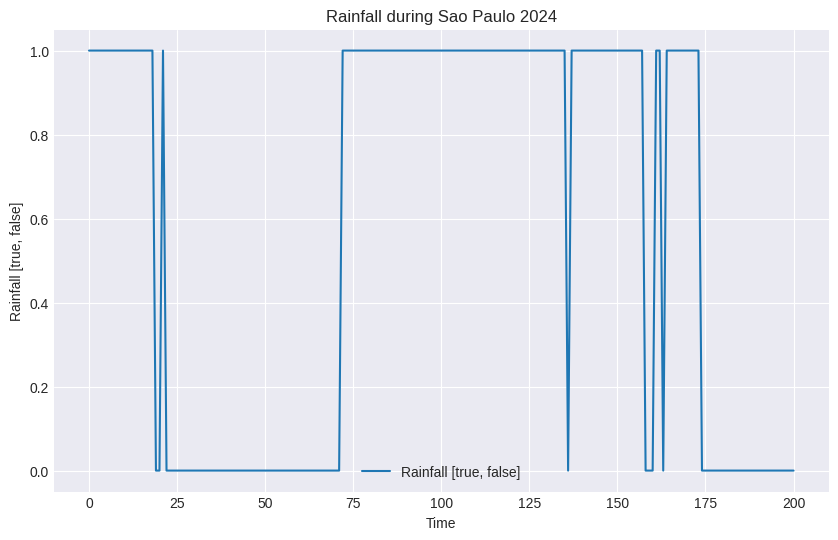

In [158]:
plt.figure(figsize=(10, 6))
plt.plot(weather['Rainfall'], label='Rainfall [true, false]')
plt.xlabel('Time')
plt.ylabel('Rainfall [true, false]')
plt.title('Rainfall during ' + SESSION_NAME + ' ' + str(SESSION_YEAR))
plt.legend()
plt.show()

## Position changes

[Position changes during a race - FastF1](https://docs.fastf1.dev/gen_modules/examples_gallery/plot_position_changes.html)

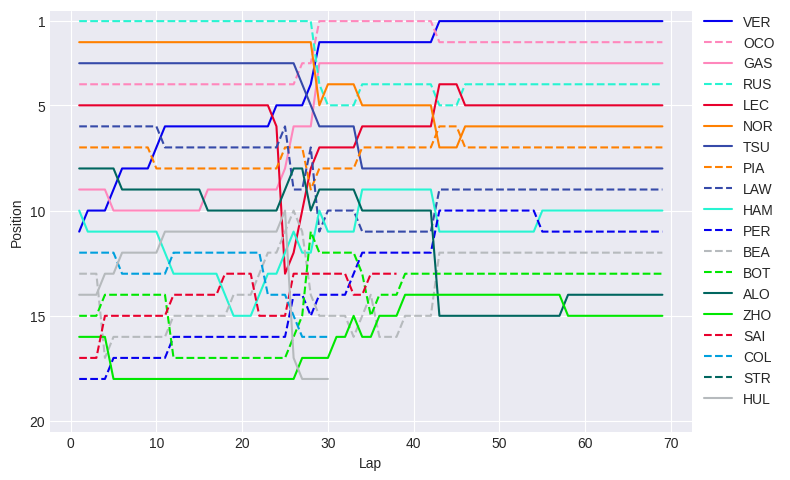

In [159]:
fig, ax = plt.subplots(figsize=(8.0, 4.9))

for drv in session.drivers:
    drv_laps = session.laps.pick_drivers(drv)

    # skip drivers without laps (prevents .iloc[0] IndexError)
    if drv_laps.empty:
        continue

    # ensure laps are ordered by lap number before plotting
    drv_laps = drv_laps.sort_values('LapNumber')

    abb = drv_laps['Driver'].iloc[0]
    style = fastf1.plotting.get_driver_style(identifier=abb,
                                             style=['color', 'linestyle'],
                                             session=session)

    ax.plot(drv_laps['LapNumber'], drv_laps['Position'],
            label=abb, **style)

ax.set_ylim([20.5, 0.5])
ax.set_yticks([1, 5, 10, 15, 20])
ax.set_xlabel('Lap')
ax.set_ylabel('Position')

ax.legend(bbox_to_anchor=(1.0, 1.02))
plt.tight_layout()

plt.show()

## Tyre Strategy

[Tyre strategies during a race - FastF1](https://docs.fastf1.dev/gen_modules/examples_gallery/plot_strategy.html)

In [160]:
stints = laps[["Driver", "Stint", "Compound", "LapNumber"]]
stints = stints.groupby(["Driver", "Stint", "Compound"])
stints = stints.count().reset_index()

stints = stints.rename(columns={"LapNumber": "StintLength"})
print(stints)

   Driver  Stint      Compound  StintLength
0     ALO    1.0  INTERMEDIATE           19
1     ALO    3.0  INTERMEDIATE           26
2     BEA    1.0  INTERMEDIATE           20
3     BEA    3.0  INTERMEDIATE           25
4     BOT    1.0  INTERMEDIATE           16
5     BOT    2.0  INTERMEDIATE           25
6     COL    1.0  INTERMEDIATE           18
7     GAS    1.0  INTERMEDIATE           20
8     GAS    2.0  INTERMEDIATE           28
9     HAM    1.0  INTERMEDIATE           19
10    HAM    3.0  INTERMEDIATE           26
11    HUL    1.0  INTERMEDIATE           20
12    LAW    1.0  INTERMEDIATE           21
13    LAW    3.0  INTERMEDIATE           25
14    LEC    1.0  INTERMEDIATE           19
15    LEC    2.0  INTERMEDIATE            1
16    LEC    3.0  INTERMEDIATE           27
17    NOR    1.0  INTERMEDIATE           24
18    NOR    3.0  INTERMEDIATE           28
19    OCO    1.0  INTERMEDIATE           23
20    OCO    2.0  INTERMEDIATE           30
21    PER    1.0  INTERMEDIATE  

### Plot Tyre Strategies

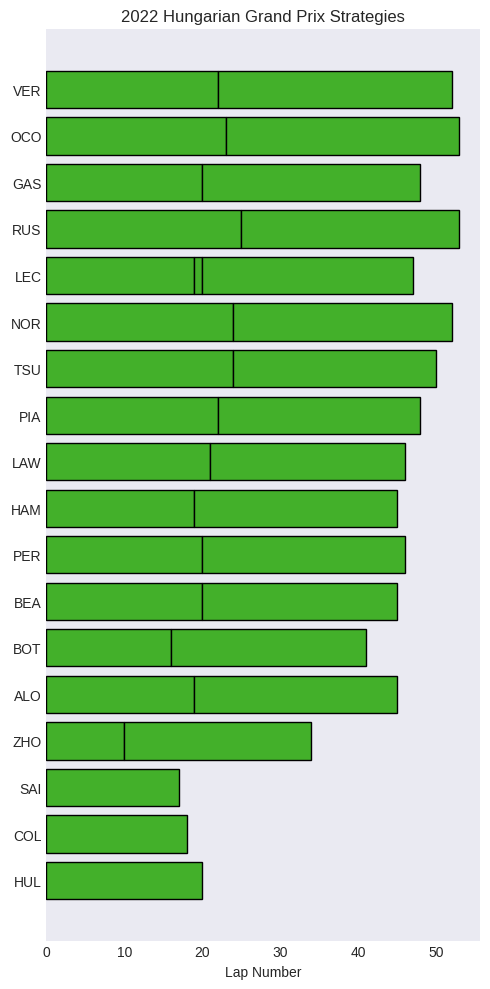

In [161]:
fig, ax = plt.subplots(figsize=(5, 10))
drivers = [session.get_driver(driver)["Abbreviation"] for driver in drivers]
for driver in drivers:
    driver_stints = stints.loc[stints["Driver"] == driver]

    previous_stint_end = 0
    for idx, row in driver_stints.iterrows():
        # each row contains the compound name and stint length
        # we can use these information to draw horizontal bars
        compound_color = fastf1.plotting.get_compound_color(row["Compound"],
                                                            session=session)
        plt.barh(
            y=driver,
            width=row["StintLength"],
            left=previous_stint_end,
            color=compound_color,
            edgecolor="black",
            fill=True
        )

        previous_stint_end += row["StintLength"]

plt.title("2022 Hungarian Grand Prix Strategies")
plt.xlabel("Lap Number")
plt.grid(False)
# invert the y-axis so drivers that finish higher are closer to the top
ax.invert_yaxis()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.tight_layout()
plt.show()

## Lap Time Distribution

[Driver Laptimes Distribution Visualization - FastF1](https://docs.fastf1.dev/gen_modules/examples_gallery/plot_laptimes_distribution.html)

In [162]:
point_finishers = drivers[:10]
print(point_finishers)
driver_laps = session.laps.pick_drivers(point_finishers).pick_quicklaps()
driver_laps = driver_laps.reset_index()

['VER', 'OCO', 'GAS', 'RUS', 'LEC', 'NOR', 'TSU', 'PIA', 'LAW', 'HAM']


In [163]:
finishing_order = [session.get_driver(i)["Abbreviation"] for i in point_finishers]
print(finishing_order)

['VER', 'OCO', 'GAS', 'RUS', 'LEC', 'NOR', 'TSU', 'PIA', 'LAW', 'HAM']


<Axes: xlabel='Driver', ylabel='LapTime(s)'>

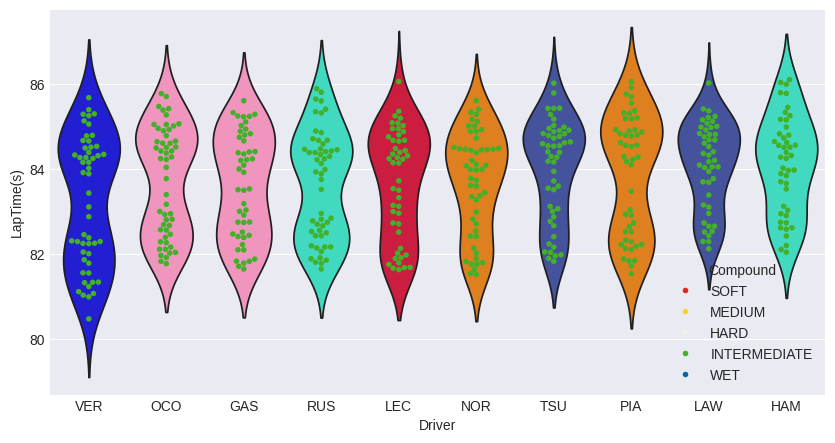

In [164]:
# create the figure
fig, ax = plt.subplots(figsize=(10, 5))

# Seaborn doesn't have proper timedelta support,
# so we have to convert timedelta to float (in seconds)
driver_laps["LapTime(s)"] = driver_laps["LapTime"].dt.total_seconds()

sns.violinplot(data=driver_laps,
               x="Driver",
               y="LapTime(s)",
               hue="Driver",
               inner=None,
               density_norm="area",
               order=finishing_order,
               palette=fastf1.plotting.get_driver_color_mapping(session=session)
               )

sns.swarmplot(data=driver_laps,
              x="Driver",
              y="LapTime(s)",
              order=finishing_order,
              hue="Compound",
              palette=fastf1.plotting.get_compound_mapping(session=session),
              hue_order=["SOFT", "MEDIUM", "HARD", "INTERMEDIATE", "WET"],
              linewidth=0,
              size=4,
              )